In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import grad
import matplotlib.pyplot as plt
import os
import wave
import struct

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [310]:
class Generator(nn.Module):
    def __init__(self, d):
        super(Generator, self).__init__()
        self.d = d
        self.linear1 = nn.Linear(100, 256*d)
        self.tconv1 = nn.ConvTranspose1d(16*d, 8*d, 25, stride = 4, padding = 3)
        self.tconv2 = nn.ConvTranspose1d(8*d, 4*d, 25, stride = 4, padding = 3)
        self.tconv3 = nn.ConvTranspose1d(4*d, 2*d, 25, stride = 4, padding = 0)
        self.tconv4 = nn.ConvTranspose1d(2*d, d, 25, stride = 4, padding = 0)
        self.tconv5 = nn.ConvTranspose1d(d, 1, 25, stride = 3, padding = 0, output_padding = 1)
    
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out.reshape(-1, 16*self.d, 16))
        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        out = F.relu(self.tconv4(out))
        out = torch.tanh(self.tconv5(out))
        return out

In [319]:
# G = nn.ConvTranspose1d(1, 2, 25, stride = 4, dilation = 1, padding = 4)
G = Generator(16)
x = 2*torch.rand(8, 100, dtype = torch.float32) - 1
G_x = G(x)
print(G_x.shape)

torch.Size([8, 1, 16226])


In [311]:
class Discriminator(nn.Module):
    def __init__(self, d):
        super(Discriminator, self).__init__()
        self.d = d
        self.conv1 = nn.Conv1d(1, d, 25, stride = 3, padding = 4)
        self.conv2 = nn.Conv1d(d, 2*d, 25, stride = 4, padding = 4)
        self.conv3 = nn.Conv1d(2*d, 4*d, 25, stride = 4, padding = 4)
        self.conv4 = nn.Conv1d(4*d, 8*d, 25, stride = 4, padding = 4)
        self.conv5 = nn.Conv1d(8*d, 16*d, 25, stride = 4, padding = 4)
        self.linear = nn.Linear(256*d, 1)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = out.reshape(-1, 256*self.d)
        out = self.linear(out)
        return out 

In [312]:
256*16

4096

In [313]:
D = Discriminator(16)
# D = nn.Conv1d(1, 2, 25, stride = 4)
x = torch.rand(8, 1, 16226, dtype = torch.float32)
D_x = D(x)
print(D_x.shape)

torch.Size([8, 1])


In [333]:
data_one = './data/speech_commands_v0.01/one/'
files = os.listdir(data_one)

In [334]:
with wave.open(os.path.join(data_one, files[0])) as f:
    params = f.getparams()

In [335]:
params

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')

In [336]:
data = []
with wave.open(os.path.join(data_one, files[0])) as f:
    data = f.readframes(params.nframes)

In [337]:
len(data)

32000

In [338]:
float_data = []
for i in range(params.nframes):
    x = struct.unpack('h', data[i:i+2])
    float_data.append(x[0])
float_data = np.array(float_data, dtype = np.float32)

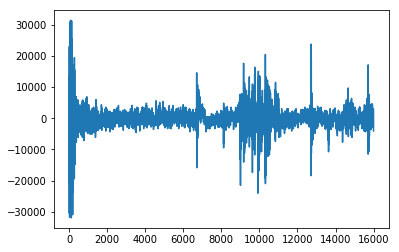

In [339]:
plt.plot(float_data)

In [340]:
float_data = np.pad(float_data, 113, 'constant', constant_values=((0, 0)))

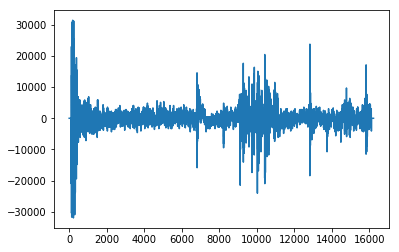

In [341]:
plt.plot(float_data)

In [342]:
float_data.shape

(16226,)

In [343]:
len(files)

2370

In [344]:
base_dir = './data/speech_commands_v0.01/'
names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# names = ['one']
# names = ['one', 'two', 'three']
files = []
for folder in os.listdir(base_dir):
    if folder in names:
        folder_files = os.listdir(os.path.join(base_dir, folder))
        base = os.path.join(base_dir, folder)
        files.extend([os.path.join(base, f) for f in folder_files])

In [345]:
len(files)

21290

In [346]:
files[0]

'./data/speech_commands_v0.01/eight\\004ae714_nohash_0.wav'

In [347]:
n_pad = 113
sample_len = 16226
train_data = []
for i, file in enumerate(files):
    with wave.open(file) as f:
        data = f.readframes(params.nframes)
    if len(data) != 32000:
        continue
    data_float = np.zeros((sample_len, ), dtype = np.float32)
    for j in range(0, len(data), 2):
        x_int = struct.unpack('h', data[j:j+2])
        data_float[n_pad + j//2] = float(x_int[0])
    train_data.append(data_float)
train_data = np.array(train_data, dtype = np.float32)

In [348]:
train_data.shape

(19359, 16226)

In [349]:
def get_batch(train_data, batch_size):
    idx = np.random.randint(0, len(train_data), size=batch_size)
    batch = train_data[idx]
    return np.expand_dims(batch, axis = 1)

In [354]:
x = get_batch(train_data, 32)
x.shape

(32, 1, 16226)

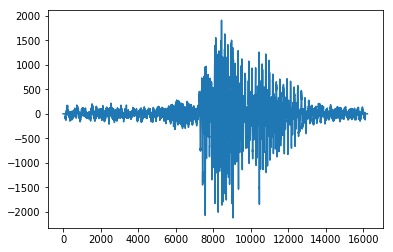

In [355]:
plt.plot(x[0][0])

In [356]:
real = torch.tensor(get_batch(train_data, batch_size))
fake = torch.rand(batch_size, 1, 16226)
eps = torch.rand(batch_size, 1, 1)
real_fake = eps*real + (1 - eps)*fake
print(real_fake.shape)

torch.Size([64, 1, 16226])


In [379]:
batch_size = 64
n = 100
n_disc = 5
r = 1
d = 32
G = Generator(d)
G.to(device)
D = Discriminator(d)
D.to(device)
G_optim = optim.Adam(G.parameters(), 1e-4, betas = (0.5, 0.9))
D_optim = optim.Adam(D.parameters(), 1e-4, betas = (0.5, 0.9))
G_losses = []
D_losses = []
D_grad_norms = []

In [380]:
for i in range(n):
    for j in range(n_disc):
        D_loss = 0
        for m in range(batch_size):
            real = get_batch(train_data, 1)
            real = torch.tensor(real).to(device)

            z = 2*torch.rand(1, 100) - 1
            z = z.to(device)
            fake = G(z)

            eps = torch.rand(1, 1, 1).to(device)
            real_fake = eps*real + (1 - eps)*fake

            D_real = D(real)
            D_fake = D(fake)
            D_real_fake = D(real_fake)

            real_fake_grad = grad(D_real_fake, real_fake, torch.ones(1, 1).to(device))[0]
            D_grad_norms.append(torch.norm(real_fake_grad, p = 2, dim = 2).to('cpu'))
            grad_penalty = r*((torch.norm(real_fake_grad, p = 2, dim = 2) - 1)**2)

            D_loss += torch.mean(D_fake - D_real + grad_penalty)
            
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        D_losses.append(D_loss.item())
    
    z = 2*torch.rand(batch_size, 100) - 1
    z = z.to(device)
    fake = G(z)
    
    G_loss = torch.mean(-D(fake))
    G_optim.zero_grad()
    G_loss.backward()
    G_optim.step()
    G_losses.append(G_loss.item())
    
    if i % 5 == 0:
        print('G_loss = {:.3}, D_loss = {:.3}'.format(G_losses[-1], D_losses[-1]))

G_loss = -0.812, D_loss = -1.53e+05
G_loss = -9.87e+03, D_loss = -1.98e+09
G_loss = -4.55e+05, D_loss = -3.76e+10
G_loss = -4.08e+06, D_loss = -2.4e+11
G_loss = -1.41e+07, D_loss = -5.44e+11
G_loss = -3.55e+07, D_loss = 3.59e+12


KeyboardInterrupt: 

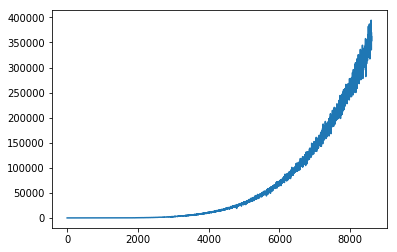

In [381]:
plt.plot(D_grad_norms)

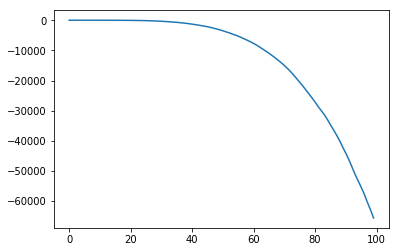

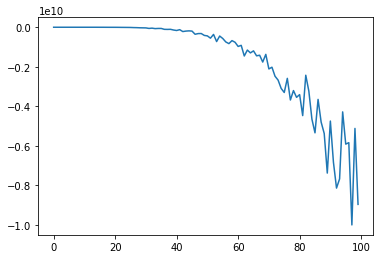

In [306]:
fig = plt.figure()
plt.plot(G_losses)
fig = plt.figure()
plt.plot(D_losses)

torch.Size([64, 1, 16226])


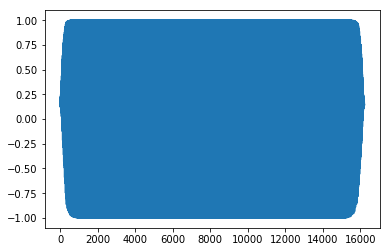

In [382]:
z = 2*torch.rand(batch_size, 100) - 1
z = z.to(device)
fake = G(z)
print(fake.shape)
fake = fake.detach().cpu().numpy()
fake = fake.squeeze()
plt.plot(fake[0])

In [220]:
class Module(nn.Module):
    def __init__(self, d):
        super(Module, self).__init__()
        self.linear = nn.Linear(d, 1)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))

In [221]:
batch_size = 16
d = 32
module = Module(d)
x = torch.rand(batch_size, d)
x.requires_grad = True
out = module(x)
g = torch.autograd.grad(out, x, torch.ones(batch_size, 1))

In [224]:
out.shape

torch.Size([16, 1])

In [223]:
g[0].shape

torch.Size([16, 32])

In [228]:
g = torch.norm(torch.rand(10, 1, 8000), p = 2, dim = 2)
g.shape

torch.Size([10, 1])